In [72]:
from codes.python import load_database,ECG_denoising
from codes.python import QRS_detector
import numpy as np
from scipy.signal import resample
from scipy.signal import savgol_filter
import operator
from numpy import array
import sys
import csv
import os
import matplotlib.pyplot as plt
import wfdb
from wfdb import processing, plot
from codes.python import heartbeat_segmentation as shs
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import pandas as pd
from codes.python import curve_smoothing 
import pywt
from biosppy.signals import ecg
import peakutils


In [2]:
mitdb = load_database.load_mitdb()
mitdb.segment_beats()

C:\Users\nimch681\Documents\git_projects\ECGdataAnalysis/database/mitdb/100
C:\Users\nimch681\Documents\git_projects\ECGdataAnalysis/database/mitdb/csv/100.csv
C:\Users\nimch681\Documents\git_projects\ECGdataAnalysis/database/mitdb/csv/100.txt
C:\Users\nimch681\Documents\git_projects\ECGdataAnalysis/database/mitdb/p_t_wave/100pt.csv
C:\Users\nimch681\Documents\git_projects\ECGdataAnalysis/database/mitdb/101
C:\Users\nimch681\Documents\git_projects\ECGdataAnalysis/database/mitdb/csv/101.csv
C:\Users\nimch681\Documents\git_projects\ECGdataAnalysis/database/mitdb/csv/101.txt
C:\Users\nimch681\Documents\git_projects\ECGdataAnalysis/database/mitdb/p_t_wave/101pt.csv
C:\Users\nimch681\Documents\git_projects\ECGdataAnalysis/database/mitdb/102
C:\Users\nimch681\Documents\git_projects\ECGdataAnalysis/database/mitdb/csv/102.csv
C:\Users\nimch681\Documents\git_projects\ECGdataAnalysis/database/mitdb/csv/102.txt
C:\Users\nimch681\Documents\git_projects\ECGdataAnalysis/database/mitdb/p_t_wave/102pt

C:\Users\nimch681\Documents\git_projects\ECGdataAnalysis/database/mitdb/csv/201.txt
C:\Users\nimch681\Documents\git_projects\ECGdataAnalysis/database/mitdb/p_t_wave/201pt.csv
C:\Users\nimch681\Documents\git_projects\ECGdataAnalysis/database/mitdb/202
C:\Users\nimch681\Documents\git_projects\ECGdataAnalysis/database/mitdb/csv/202.csv
C:\Users\nimch681\Documents\git_projects\ECGdataAnalysis/database/mitdb/csv/202.txt
C:\Users\nimch681\Documents\git_projects\ECGdataAnalysis/database/mitdb/p_t_wave/202pt.csv
C:\Users\nimch681\Documents\git_projects\ECGdataAnalysis/database/mitdb/203
C:\Users\nimch681\Documents\git_projects\ECGdataAnalysis/database/mitdb/csv/203.csv
C:\Users\nimch681\Documents\git_projects\ECGdataAnalysis/database/mitdb/csv/203.txt
C:\Users\nimch681\Documents\git_projects\ECGdataAnalysis/database/mitdb/p_t_wave/203pt.csv
C:\Users\nimch681\Documents\git_projects\ECGdataAnalysis/database/mitdb/205
C:\Users\nimch681\Documents\git_projects\ECGdataAnalysis/database/mitdb/csv/205

Filtered MLII records from : 102
start segmenting MLII.
Finished segmenting MLII.
Segmenting record 102 completes.
Start segmenting records: 103
Filtered MLII records from : 103
start segmenting MLII.
Finished segmenting MLII.
Segmenting record 103 completes.
Start segmenting records: 104
Filtered MLII records from : 104
start segmenting MLII.
Finished segmenting MLII.
Segmenting record 104 completes.
Start segmenting records: 105
Filtered MLII records from : 105
start segmenting MLII.
Finished segmenting MLII.
Segmenting record 105 completes.
Start segmenting records: 106
Filtered MLII records from : 106
start segmenting MLII.
Finished segmenting MLII.
Segmenting record 106 completes.
Start segmenting records: 107
Filtered MLII records from : 107
start segmenting MLII.
Finished segmenting MLII.
Segmenting record 107 completes.
Start segmenting records: 108
Filtered MLII records from : 108
start segmenting MLII.
Finished segmenting MLII.
Segmenting record 108 completes.
Start segmentin

In [30]:

def is_class_MIT(classAnttd):
    MITBIH_classes = ['N', 'L', 'R', 'e', 'j', 'A', 'a', 'J', 'S', 'V', 'E', 'F']#, 'P', '/', 'f', 'u']
    if classAnttd in MITBIH_classes:
        return True
    else:
        return False
        

def check_class_AAMI(classAnttd, class_AAMI):
    AAMI_classes = []
    AAMI_classes.append(['N', 'L', 'R'])                    # N
    AAMI_classes.append(['A', 'a', 'J', 'S', 'e', 'j'])     # SVEB 
    AAMI_classes.append(['V', 'E'])                         # VEB
    AAMI_classes.append(['F'])
    for i in range(0,len(AAMI_classes)):

        if classAnttd in AAMI_classes[i]:
            class_AAMI = i      

    return class_AAMI

def segment(signal,pos,winL,winR,size_RR_max):
    lst = list(signal[pos - size_RR_max : pos + size_RR_max])
    
    
    if(signal[pos] < 0):
        beat_pos = [abs(x) for x in lst]
        beat_pos = enumerate(beat_pos)
        index, value  = max(beat_pos, key=operator.itemgetter(1))
        pos = (pos - size_RR_max) + index
    
    else:
        beat_pos = enumerate(lst)
        index, value  = max(beat_pos, key=operator.itemgetter(1))
        pos = (pos - size_RR_max) + index

    beat_poses = list(range(pos - winL, pos + winR))
    beat_poses = [int(i) for i in beat_poses]
    return beat_poses,pos

def r_peak_and_annotation(signal,annotations, indexes, winL=180, winR=180,size_RR_max=5):
    class_ID = []
    
    originalPoses = []
   
    R_poses = []
    beat_class = []
    class_AAMI = -1
    
    for a in annotations:
    
        aS = a.split()
        pos = int(aS[1])

       

        if(len(signal) < len(indexes)):
            break

        if(indexes[len(indexes)-1] < pos):
            break

        if(indexes[0] > pos):
            continue
        
        originalPos = int(aS[1])
        classAnttd = str(aS[2])

        if pos > size_RR_max and pos < (len(signal) - size_RR_max):
            beat_poses,pos=segment(signal,pos,winL,winR, size_RR_max)
        #time_beat = list(time[beat_poses[0] : beat_poses[len(beat_poses)-1]+1])
            pos = pos - indexes[0]
            if(pos > winL and pos < (len(indexes) - winR)):
                
                R_poses.append(pos)
                class_AAMI = check_class_AAMI(classAnttd, class_AAMI)
                class_ID.append(class_AAMI)
                beat_class.append(classAnttd)
                originalPos = originalPos-indexes[0]
                originalPoses.append(originalPos)

    return beat_class, class_ID, R_poses, originalPoses

def segment_beat(signal,r_poses, upper_left_limit=0, upper_right_limit=0, winL=180,  winR=180,size_RR_max=5):
    upper_left_limit = winL+upper_left_limit
    upper_right_limit = winR+upper_right_limit
    beats = []
    beat_pos = []
    for pos in r_poses:
        
        if pos > size_RR_max and pos < (len(signal) - size_RR_max ):
            beat_poses,pos=segment(signal,pos,winL,winR, size_RR_max)
            if(pos <= upper_left_limit):
                beat = signal[pos - winL : pos + upper_right_limit]
                beat_poses = list(range(pos - winL, pos + upper_right_limit))
                beat_poses = [int(i) for i in beat_poses]
                #print(beat, pos)
                
            if(pos >= (len(signal) - upper_right_limit)):
                beat = signal[pos - upper_left_limit : pos + winR]
                beat_poses = list(range(pos - upper_left_limit, pos + winR))
                beat_poses = [int(i) for i in beat_poses]
               # print("here", str(pos))
                #print(beat)

            if(pos > upper_left_limit and pos < (len(signal) - upper_right_limit)):
                
                beat = signal[pos - upper_left_limit : pos + upper_right_limit]
                beat_poses = list(range(pos - upper_left_limit, pos + upper_right_limit))
                beat_poses = [int(i) for i in beat_poses]
                
            if(pos > winL and pos < (len(signal) - winR)):
                beats.append(beat)
                beat_pos.append(beat_poses)
                
                #print(pos)
                
    return np.asarray(beats), np.asarray(beat_pos)

def r_peak(signal,r_peak, winL=180, winR=180,size_RR_max=5):
    
    R_poses = []
    class_AAMI = -1
    for r in r_peak:
        pos = r
        if(pos > len(signal)):
            break  
        
        if pos > size_RR_max and pos < (len(signal) - size_RR_max):
            beat_poses,pos=segment(signal,pos,winL,winR, size_RR_max)
            
            if(pos > winL and pos < (len(signal) - winR)):
               
                R_poses.append(pos)
                
    return R_poses


def average(numbers):
    return float(sum(numbers)) / len(numbers)

In [4]:
mit100 = load_database.load_patient_record("mitdb","100")
mit100.set_segmented_beats_r_pos(winL=100,winR=200)



C:\Users\nimch681\Documents\git_projects\ECGdataAnalysis/database/mitdb/100
C:\Users\nimch681\Documents\git_projects\ECGdataAnalysis/database/mitdb/csv/100.csv
C:\Users\nimch681\Documents\git_projects\ECGdataAnalysis/database/mitdb/csv/100.txt
C:\Users\nimch681\Documents\git_projects\ECGdataAnalysis/database/mitdb/p_t_wave/100pt.csv
Start segmenting records: 100
Filtered MLII records from : 100
start segmenting MLII.
Finished segmenting MLII.
Segmenting record 100 completes.


In [6]:
beats, beat_pos = segment_beat(mit100.filtered_MLII, mit100.segmented_R_pos,upper_left_limit=300, upper_right_limit=300)

[191,
 192,
 193,
 194,
 195,
 196,
 197,
 198,
 199,
 200,
 201,
 202,
 203,
 204,
 205,
 206,
 207,
 208,
 209,
 210,
 211,
 212,
 213,
 214,
 215,
 216,
 217,
 218,
 219,
 220,
 221,
 222,
 223,
 224,
 225,
 226,
 227,
 228,
 229,
 230,
 231,
 232,
 233,
 234,
 235,
 236,
 237,
 238,
 239,
 240,
 241,
 242,
 243,
 244,
 245,
 246,
 247,
 248,
 249,
 250,
 251,
 252,
 253,
 254,
 255,
 256,
 257,
 258,
 259,
 260,
 261,
 262,
 263,
 264,
 265,
 266,
 267,
 268,
 269,
 270,
 271,
 272,
 273,
 274,
 275,
 276,
 277,
 278,
 279,
 280,
 281,
 282,
 283,
 284,
 285,
 286,
 287,
 288,
 289,
 290,
 291,
 292,
 293,
 294,
 295,
 296,
 297,
 298,
 299,
 300,
 301,
 302,
 303,
 304,
 305,
 306,
 307,
 308,
 309,
 310,
 311,
 312,
 313,
 314,
 315,
 316,
 317,
 318,
 319,
 320,
 321,
 322,
 323,
 324,
 325,
 326,
 327,
 328,
 329,
 330,
 331,
 332,
 333,
 334,
 335,
 336,
 337,
 338,
 339,
 340,
 341,
 342,
 343,
 344,
 345,
 346,
 347,
 348,
 349,
 350,
 351,
 352,
 353,
 354,
 355,
 356,
 357

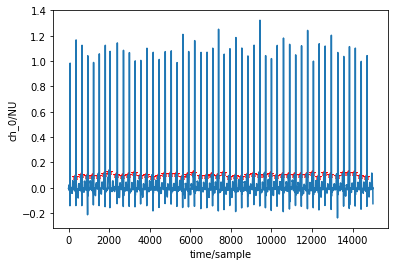

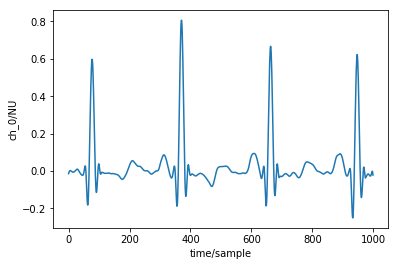

In [25]:
p_waves = mit100.annotated_p_waves_pos[0:50]

filtered_np100 = savgol_filter(mit100.filtered_MLII[0:1000],51,7)

p_waves = [int(b) for b in p_waves]
#p_waves = list([210, 400])
p_wave = np.asarray(p_waves)
wfdb.plot_items(signal=mit100.filtered_MLII[0:15000], ann_samp=[p_wave])
wfdb.plot_items(signal=filtered_np100)#, ann_samp=[p_wave])



In [49]:
p_waves = []
t_waves = []
averages_p = []
averages_t = []
diffs_p = []
diffs_t = []
max_diff = 1000
for i in mitdb.patient_records:
    diffs = []
    p_waves.extend(i.annotated_p_waves_pos)
    t_waves.extend(i.annotated_t_waves_pos)
    for j in range(0,len(i.annotated_p_waves_pos)-1):
        diff=i.annotated_p_waves_pos[j+1] - i.annotated_p_waves_pos[j]
        if(diff <= max_diff):
            diffs.append(diff)
        
    diffs_p.extend(diffs)
    averages = round(average(diffs),2)
    averages_p.append(averages)
    
    diffs = []
    for j in range(0,len(i.annotated_t_waves_pos)-1):
        diff=i.annotated_t_waves_pos[j+1] - i.annotated_t_waves_pos[j]
        if(diff <= max_diff):
            diffs.append(diff)
    diffs_t.extend(diffs)
    averages = round(average(diffs),2)
    averages_t.append(averages)
    #averages_p.append(round(average(p_waves),2))
    #averages_t.append(round(average(t_wavess),2))
    
    
p_waves = [int(b) for b in p_waves]
t_waves = [int(t) for t in t_waves]

In [54]:
r_peaks = []

for i in mitdb.patient_records:
    
    r_peaks.extend(i.segmented_R_pos)
   
    
    


In [55]:
len(r_peaks)

112543

In [40]:

p_all_diffs = []

for i in range(0, len(p_waves)-1):
    
        
    diff=p_waves[i+1] - p_waves[i]
        
    p_all_diffs.append(diff)



t_all_diffs = []

for i in range(0, len(t_waves)-1):
    
        
    diff=t_waves[i+1] - t_waves[i]
        
    t_all_diffs.append(diff)
 

1377

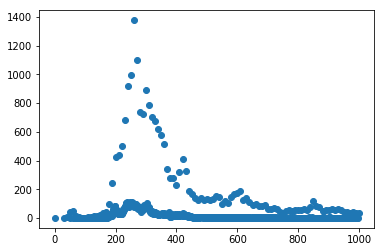

In [53]:
x ,y  = np.unique(diffs_p, return_counts=True) # counting occurrence of each loan
plt.scatter(x,y)



In [18]:


filtered_np100 = savgol_filter(mit100.filtered_MLII[0:1000],51,7)

peaks = processing.find_peaks(filtered_np100)

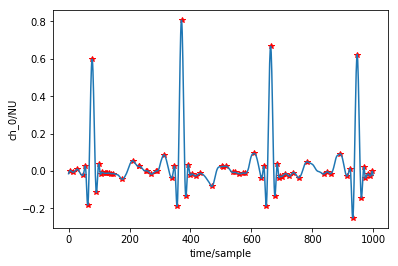

In [8]:
wfdb.plot_items(signal=filtered_np100, ann_samp=[peaks[0]])

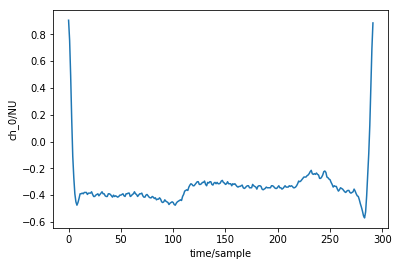

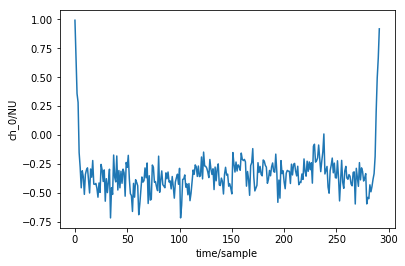

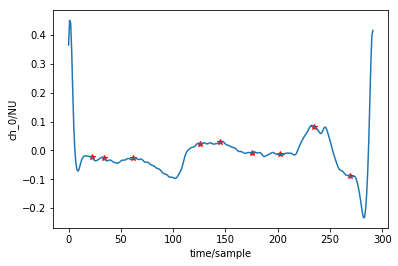

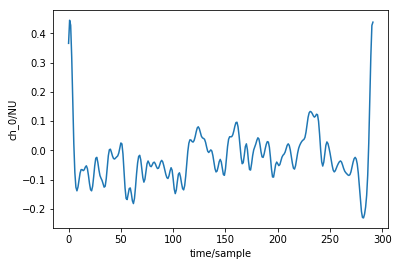

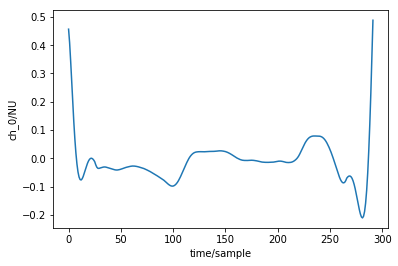

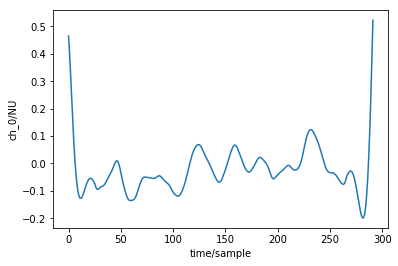

In [79]:
signal = mit100.MLII[mit100.segmented_R_pos[0]:mit100.segmented_R_pos[1]]
noise = np.random.normal(0,0.1,len(signal))
noisy = signal + noise
filter_FIR = ECG_denoising.ECG_FIR_filter()

filtered_signal = ECG_denoising.denoising_signal_FIR(signal,filter_FIR)
filtered_noisy = ECG_denoising.denoising_signal_FIR(noisy,filter_FIR)

savgol_signal = savgol_filter(filtered_signal,51,7)
savgol_noisy = savgol_filter(filtered_noisy,51,7)
savgol_signal = np.array(savgol_signal)
indices = peakutils.indexes(savgol_signal, thres=0.02/max(savgol_signal), min_dist=0.1)

wfdb.plot_items(signal=signal)
wfdb.plot_items(signal=noisy)
wfdb.plot_items(signal=filtered_signal,  ann_samp=[indices])
wfdb.plot_items(signal=filtered_noisy)
wfdb.plot_items(signal=savgol_signal)
wfdb.plot_items(signal=savgol_noisy)

In [74]:
type(indices)

numpy.ndarray

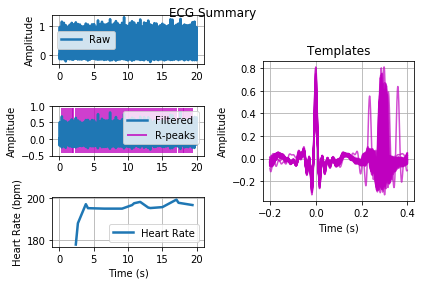

ReturnTuple(ts=array([0.00000000e+00, 9.99950000e-04, 1.99990000e-03, ...,
       1.99960001e+01, 1.99970001e+01, 1.99980000e+01]), filtered=array([-0.0003341 ,  0.00624591,  0.01219573, ...,  0.24316532,
        0.12326382, -0.00136264]), rpeaks=array([  371,   663,   947,  1232,  1515,  1810,  2045,  2403,  2706,
        2998,  3283,  3560,  3863,  4171,  4466,  4765,  5061,  5347,
        5634,  5919,  6215,  6527,  6824,  7106,  7392,  7670,  7953,
        8246,  8540,  8838,  9142,  9432,  9711,  9999, 10283, 10591,
       10895, 11192, 11481, 11781, 12067, 12350, 12645, 12950, 13267,
       13563, 13842, 14131, 14424, 14711, 15012, 15311, 15608, 15900,
       16183, 16465, 16756, 17059, 17359, 17657, 17947, 18227, 18514,
       18796, 19081, 19389]), templates_ts=array([-2.00000000e-01, -1.99000000e-01, -1.98000000e-01, -1.97000000e-01,
       -1.96000000e-01, -1.95000000e-01, -1.94000000e-01, -1.93000000e-01,
       -1.92000000e-01, -1.91000000e-01, -1.90000000e-01, -1.89000000e

In [39]:
out = ecg.ecg(signal=mit100.filtered_MLII[0:20000], sampling_rate=1000., show=True)
out

array([  -7.05488023,    9.90653683,   -8.71190629,   16.39202077,
        -43.50723903,   26.49031196, -233.277176  , -128.92083533,
         88.16272042,  -59.114004  ,   32.72869946, -148.4961644 ,
         86.61578887,   -6.63160191,  -66.49628227,    2.26209315,
         19.07855788,  300.34763819,  -60.01811736,  -30.69693998,
          7.27693911,   -4.24287829,    5.4669691 ,  -16.1136547 ])

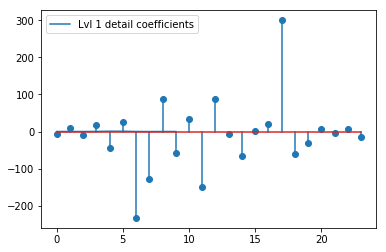

In [66]:
x = pywt.data.ecg()
#plt.plot(x)
#plt.legend(['Original signal'])
w = pywt.Wavelet('sym5')
plt.plot(w.dec_lo)
coeffs = pywt.wavedec(x, w, level=6)
plt.stem(coeffs[1]); plt.legend(['Lvl 1 detail coefficients'])

coeffs[1]

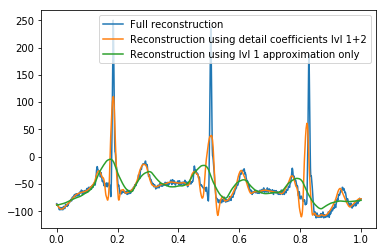

In [60]:
def reconstruction_plot(yyy, **kwargs):
    """Plot signal vector on x [0,1] independently of amount of values it contains."""
    plt.plot(np.linspace(0, 1, len(yyy)), yyy, **kwargs)

reconstruction_plot(pywt.waverec(coeffs, w)) # full reconstruction 
#reconstruction_plot(pywt.waverec(coeffs[:-1] + [None] * 1, w)) # leaving out detail coefficients up to lvl 5
#reconstruction_plot(pywt.waverec(coeffs[:-2] + [None] * 2, w)) # leaving out detail coefficients up to lvl 4
#reconstruction_plot(pywt.waverec(coeffs[:-3] + [None] * 3, w)) # leaving out detail coefficients up to lvl 3
reconstruction_plot(pywt.waverec(coeffs[:-4] + [None] * 4, w)) # leaving out detail coefficients up to lvl 2
#reconstruction_plot(pywt.waverec(coeffs[:-5] + [None] * 5, w)) # leaving out detail coefficients up to lvl 1
reconstruction_plot(pywt.waverec(coeffs[:-6] + [None] * 6, w)) # leaving out all detail coefficients = reconstruction using lvl1 approximation only
plt.legend(['Full reconstruction', 'Reconstruction using detail coefficients lvl 1+2', 'Reconstruction using lvl 1 approximation only'])